# Credit Card Fraud Detection

This notebook uses the open source Kaggle dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud/home

"The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

*Based on the above description, we already know that this dataset is going to be very imbalanced so we will work through several techniques to deal with that*

In [14]:
import boto3
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import sagemaker.amazon.common as smac
import os
import sagemaker
from __future__ import division

%matplotlib inline

## Load in the dataset and inspect the classes

In [2]:
data = pd.read_csv("credit-data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0,0.5,'Frequency')

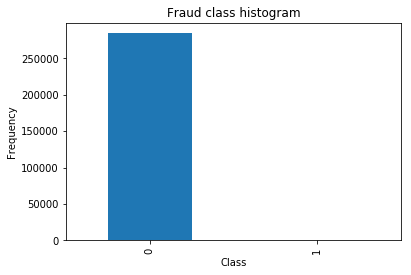

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

How often are the fraudulent transactions occuring?


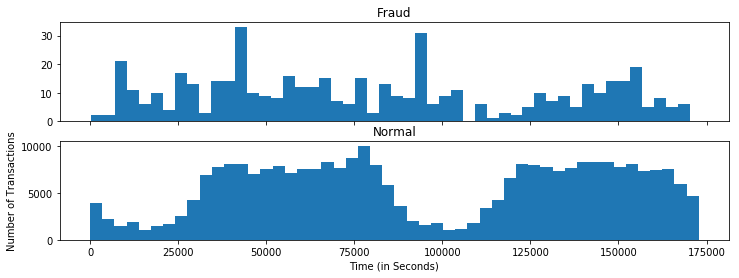

In [4]:
print('How often are the fraudulent transactions occuring?')
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

How much money is spent in fraudulent transactions?


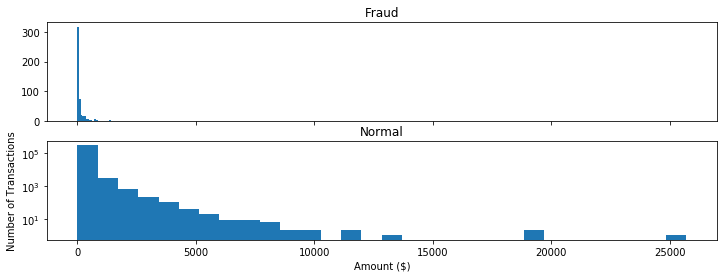

In [5]:
print('How much money is spent in fraudulent transactions?')
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

We need to normalize this dataset! There are 285,299 transactions in this dataset and only 492 are fraudulant. So if we simply classified everything as non-fradulant, we would still get 99.83% accuracy (284807/285299)! This data will need to be normalized to improve our classifier's performance. 

## Resampling the dataset

This change is called sampling your dataset and there are two main methods that you can use to even-up the classes:
- You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
- You can delete instances from the over-represented class, called under-sampling.

In [6]:
# We are removing the Time and Amount columns because they have too much variance and will confuse our classifier
# Standardization of a dataset is a common requirement for many machine learning estimators: 
#    they might behave badly if the individual feature do not more or less look like standard normally 
#    distributed data (e.g. Gaussian with 0 mean and unit variance).

from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


## Undersampling to Normalize the Data

The following section of code will undersample the data and then divide it into test and training classes

In [7]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [8]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]


X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: " + str(len(under_sample_data[under_sample_data.Class == 0])))
print("Percentage of fraud transactions: "+ str(len(under_sample_data[under_sample_data.Class == 1])))
print("Total number of transactions in resampled data: "+ str(len(under_sample_data)))

Percentage of normal transactions: 492
Percentage of fraud transactions: 492
Total number of transactions in resampled data: 984


In [9]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: "+ str(len(X_train)))
print("Number transactions test dataset: "+ str(len(X_test)))
print("Total number of transactions: "+ str(len(X_train)+len(X_test)))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: "+ str(len(X_train_undersample)))
print("Number transactions test dataset: "+ str(len(X_test_undersample)))
print("Total number of transactions: "+ str(len(X_train_undersample)+len(X_test_undersample)))

Number transactions train dataset: 199364
Number transactions test dataset: 85443
Total number of transactions: 284807

Number transactions train dataset: 688
Number transactions test dataset: 296
Total number of transactions: 984


## K-Means Clustering Test

This next section will use scikit-learn's K-Means clustering model to do some testing locally in the notebook. I want to see how well this data clusers to determine if SageMaker's built-in linear learning may be a viable fit for this dataset

In [10]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X_scaled = scale(X_undersample)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

X_ktrain, X_ktest, y_ktrain, y_ktest = train_test_split(X_reduced, y_undersample, test_size = 0.33, random_state=500)


In [11]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(X_ktrain)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

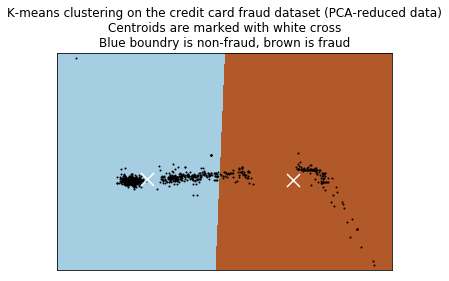

In [12]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_reduced[:, 0], X_reduced[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the credit card fraud dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross\n'
          'Blue boundry is non-fraud, brown is fraud')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
predictions = kmeans.predict(X_ktest)

pred_fraud = np.where(predictions == 1)[0]
real_fraud = np.where(y_ktest == 1)[0]
false_pos = len(np.setdiff1d(pred_fraud, real_fraud))

pred_good = np.where(predictions == 0)[0]
real_good = np.where(y_ktest == 0)[0]
false_neg = len(np.setdiff1d(pred_good, real_good))

false_neg_rate = false_neg/(false_pos+false_neg)

accuracy = (len(X_ktest) - (false_neg + false_pos)) / len(X_ktest)
print("Accuracy:", accuracy)

('Accuracy:', 0.6461538461538462)


## t-SNE Visualization

Hmm, the k-means clustering produced 'okay' results. Lets look at the data another way to see if we feel more comfortable applying a linear classifier. We could be using a lot of details when we apply PCA to the dataset. So lets try using t-Distributed Stochastic Neighbor Embedding (t-SNE). t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. 

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X_undersample)

In [38]:
colors = ['G' if i==0 else 'R' for i in y_undersample.Class]

df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = [0 if i==0 else 1 for i in y_undersample.Class]
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,Class,color,x,y
0,1,R,19.907938,33.431881
1,1,R,4.823744,-9.290974
2,1,R,13.721819,29.941467
3,1,R,5.954228,47.680744
4,1,R,-1.976492,12.285918


In [39]:
# number of rows and columns
df_tsne.shape

(984, 4)

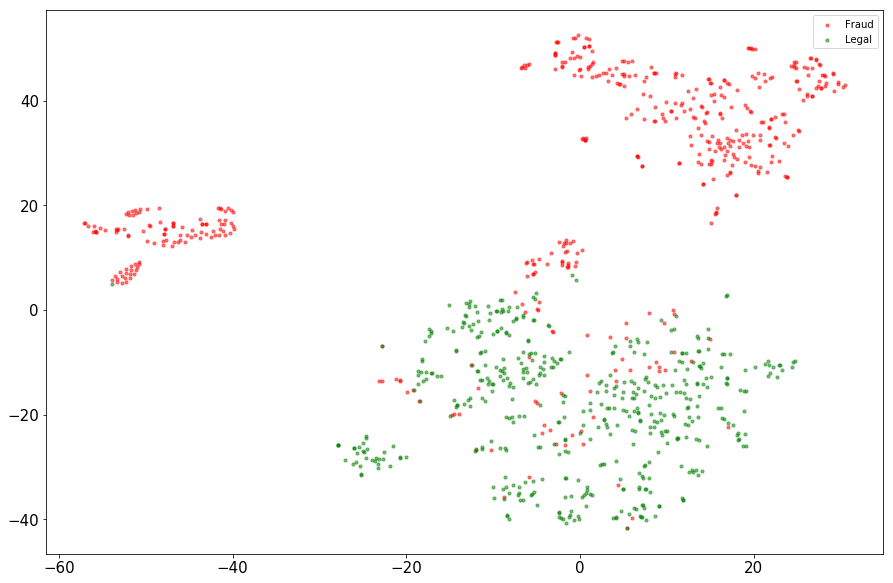

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Fraud')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Legal')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show();

## Train using SageMaker's Linear Learner

Based on the seperability of the fraud data above, I think Linear Learner will be able to produce some decent results so lets give it a try.

In [37]:
# Configure SageMaker for a training job
bucket = '951232522638-sagemaker-us-east-1'
prefix = 'sagemaker/credit-card'
 
# Define IAM role
role = sagemaker.get_execution_role()

In [83]:
vectors = np.array(np.array(X_train_undersample).tolist()).astype('float32')
labels = np.array(np.array(y_train_undersample.Class).tolist()).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0L

In [84]:
key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://951232522638-sagemaker-us-east-1/sagemaker/credit-card/train/recordio-pb-data


In [85]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://951232522638-sagemaker-us-east-1/sagemaker/credit-card/output


In [86]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest',
              'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/linear-learner:latest',
              'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/linear-learner:latest'}

In [87]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=29,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-07-10-00-05-48-577


.....................
Docker entrypoint called with argument(s): train
[07/10/2018 00:09:07 INFO 139915021735744] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_crit

===== Job Complete =====
Billable seconds: 98


## Lets see how the initial model performed using a Confusion Matrix

In [88]:
# Deploy the SageMaker endpoint
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-07-10-00-31-36-025
INFO:sagemaker:Creating endpoint with name linear-learner-2018-07-10-00-05-48-577


---------------------------------------------------------------------------!

In [89]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [91]:
predictions = []

for array in np.array_split(X_test_undersample, 100):
    array = np.array(array).tolist()
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [93]:
pd.crosstab(y_test_undersample.Class, predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,144,5
1,13,134


In [119]:
TN = (134/139)*100
TP = (144/157)*100

print('Normalized Data')
print('Fraud Detection Accuracy: '+ "{0:.2f}".format(TN)+ '%')
print('Non-Fraud Detection Accuracy: '+ "{0:.2f}".format(TP)+ '%')

Normalized Data
Fraud Detection Accuracy: 96.40%
Non-Fraud Detection Accuracy: 91.72%


## For Comparison, lets repeat the above steps but using the original dataset

If the normalization is working correctly, this model should have worse performance than the one above.

In [107]:
vectors = np.array(np.array(X_train).tolist()).astype('float32')
labels = np.array(np.array(y_train.Class).tolist()).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0L

In [108]:
key = 'recordio-pb-data-nonorm'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://951232522638-sagemaker-us-east-1/sagemaker/credit-card/train/recordio-pb-data-nonorm


In [109]:
sess = sagemaker.Session()

linear_nonorm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear_nonorm.set_hyperparameters(feature_dim=29,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear_nonorm.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-07-10-00-49-56-501


....................
Docker entrypoint called with argument(s): train
[07/10/2018 00:53:08 INFO 139888713291584] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_crite

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005684612167468033, "sum": 0.005684612167468033, "min": 0.005684612167468033}}, "EndTime": 1531184043.282013, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1531184043.28195}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004816275924204822, "sum": 0.004816275924204822, "min": 0.004816275924204822}}, "EndTime": 1531184043.282091, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1531184043.282078}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005681676629437022, "sum": 0.005681676629437022, "min": 0.005681676629437022}}, "EndTime": 1531184043.282141, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004965621867482681, "sum": 0.004965621867482681, "min": 0.004965621867482681}}, "EndTime": 1531184070.756722, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1531184070.756664}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004362258930544717, "sum": 0.004362258930544717, "min": 0.004362258930544717}}, "EndTime": 1531184070.756802, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1531184070.756789}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004965247647260806, "sum": 0.004965247647260806, "min": 0.004965247647260806}}, "EndTime": 1531184070.756839, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorith

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0047362542147916485, "sum": 0.0047362542147916485, "min": 0.0047362542147916485}}, "EndTime": 1531184098.018664, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1531184098.018605}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004241704844559232, "sum": 0.004241704844559232, "min": 0.004241704844559232}}, "EndTime": 1531184098.018739, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1531184098.018727}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004736376661642727, "sum": 0.004736376661642727, "min": 0.004736376661642727}}, "EndTime": 1531184098.018775, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algor

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004642245423003851, "sum": 0.004642245423003851, "min": 0.004642245423003851}}, "EndTime": 1531184126.443418, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1531184126.443334}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004214839830725308, "sum": 0.004214839830725308, "min": 0.004214839830725308}}, "EndTime": 1531184126.443529, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1531184126.443503}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00462895896712161, "sum": 0.00462895896712161, "min": 0.00462895896712161}}, "EndTime": 1531184126.443578, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm":

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004599119139663187, "sum": 0.004599119139663187, "min": 0.004599119139663187}}, "EndTime": 1531184154.955618, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1531184154.955559}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004158394779733206, "sum": 0.004158394779733206, "min": 0.004158394779733206}}, "EndTime": 1531184154.955696, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1531184154.955683}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004531413817022699, "sum": 0.004531413817022699, "min": 0.004531413817022699}}, "EndTime": 1531184154.955746, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorith

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045773979137281335, "sum": 0.0045773979137281335, "min": 0.0045773979137281335}}, "EndTime": 1531184184.600646, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1531184184.600579}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004157242635283694, "sum": 0.004157242635283694, "min": 0.004157242635283694}}, "EndTime": 1531184184.600727, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1531184184.600715}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004436824011979213, "sum": 0.004436824011979213, "min": 0.004436824011979213}}, "EndTime": 1531184184.600778, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algor

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004558850782642882, "sum": 0.004558850782642882, "min": 0.004558850782642882}}, "EndTime": 1531184212.742111, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1531184212.742049}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004107639449779468, "sum": 0.004107639449779468, "min": 0.004107639449779468}}, "EndTime": 1531184212.74219, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1531184212.742178}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004358705553753548, "sum": 0.004358705553753548, "min": 0.004358705553753548}}, "EndTime": 1531184212.742239, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0045383656310688065, "sum": 0.0045383656310688065, "min": 0.0045383656310688065}}, "EndTime": 1531184240.889384, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1531184240.889319}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004113146216818038, "sum": 0.004113146216818038, "min": 0.004113146216818038}}, "EndTime": 1531184240.889464, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1531184240.889451}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004301240581450572, "sum": 0.004301240581450572, "min": 0.004301240581450572}}, "EndTime": 1531184240.889511, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algor

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004517856973960218, "sum": 0.004517856973960218, "min": 0.004517856973960218}}, "EndTime": 1531184269.579572, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1531184269.579512}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004073932972478579, "sum": 0.004073932972478579, "min": 0.004073932972478579}}, "EndTime": 1531184269.579659, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1531184269.57964}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004260289559447502, "sum": 0.004260289559447502, "min": 0.004260289559447502}}, "EndTime": 1531184269.579711, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

===== Job Complete =====
Billable seconds: 405


In [111]:
# Deploy the SageMaker endpoint
linear_nonorm_predictor = linear_nonorm.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-07-10-00-59-05-066
INFO:sagemaker:Creating endpoint with name linear-learner-2018-07-10-00-49-56-501


---------------------------------------------------------------------------!

In [112]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_nonorm_predictor.content_type = 'text/csv'
linear_nonorm_predictor.serializer = csv_serializer
linear_nonorm_predictor.deserializer = json_deserializer

In [116]:
predictions_nonorm = []

for array in np.array_split(X_test, 100):
    array = np.array(array).tolist()
    result = linear_nonorm_predictor.predict(array)
    predictions_nonorm += [r['predicted_label'] for r in result['predictions']]

predictions_nonorm = np.array(predictions)

In [117]:
pd.crosstab(y_test.Class, predictions_nonorm, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,85275,21
1,31,116


In [120]:
TN_nonorm = (116/137)*100
TP_nonorm = (85275/85306)*100

print('Non-normalized Data')
print('Fraud Detection Accuracy: '+ "{0:.2f}".format(TN_nonorm)+ '%')
print('Non-Fraud Detection Accuracy: '+ "{0:.2f}".format(TP_nonorm)+ '%')

Non-normalized Data
Fraud Detection Accuracy: 84.67%
Non-Fraud Detection Accuracy: 99.96%


So the normalization technique gave us a 10% performance gain in fraud detection, but it also increase the number of false positives for non-fraudulent activity, resulting in a 8% performance decrease. Given the scenario, it is probably okay to have a higher false alarm rate. I would rather be alerted by my credit card company for a transaction that it thinks is fraudulent when its not, then to not have the company identify a truely fraudulent transaction.